## Evaluation Metrics and Scoring

So far, we have evaluated classification performance using accuracy (the fraction of correctly classified samples) and regression performance using R2. However, these are only two of the many possible ways to summarize how well a supervised model performs on a given dataset. In practice, these evaluation metrics might not be appropriate for your application, and it is important to choose the right metric when selecting between models and adjusting parameters.

### Keep the End Goal in Mind

When selecting a metric, you should always have the end goal of the machine learning application in mind. In practice, we are usually interested not just in making accurate predictions, but in using these predictions as part of a larger decision-making process. Before picking a machine learning metric, you should think about the high-level goal of the application, often called the *business metric*. The consequences of choosing a particular algorithm for a machine learning application are called the *business impact*. 

Maybe the high-level goal is avoiding traffic accidents, or decreasing the number of hospital admissions. It could also be getting more users for your website, or having users spend more money in your shop. When choosing a model or adjusting parameters, you should pick the model or parameter values that have the most positive influence on the business metric. Often this is hard, as assessing the business impact of a particular model might require putting it in production in a real-life system.

In the early stages of development, and for adjusting parameters, it is often infeasible to put models into production just for testing purposes, because of the high business or personal risks that can be involved. Imagine evaluating the pedestrian avoidance capabilities of a self-driving car by just letting it drive around, without verifying it first; if your model is bad, pedestrians will be in trouble! 

Therefore we often need to find some surrogate evaluation procedure, using an evaluation metric that is easier to compute. For example, we could test classifying images of pedestrians against non-pedestrians and measure accuracy. Keep in mind that this is only a surrogate, and it pays off to find the closest metric to the original business goal that is feasible to evaluate. This closest metric should be used whenever possible for model evaluation and selection. The result of this evaluation might not be a single number—the consequence of your algorithm could be that you have 10% more customers, but each customer will spend 15% less—but it should capture the expected business impact of choosing one model over another.

In this section, we will first discuss metrics for the important special case of binary classification, then turn to multiclass classification and finally regression.

### Metrics for Binary Classification

Binary classification is arguably the most common and conceptually simple application of machine learning in practice. However, there are still a number of caveats in evaluating even this simple task. Before we dive into alternative metrics, let’s have a look at the ways in which measuring accuracy might be misleading. Remember that for binary classification, we often speak of a *positive class* and a *negative class*, with the understanding that the positive class is the one we are looking for.

#### Kinds of Errors

Often, accuracy is not a good measure of predictive performance, as the number of mistakes we make does not contain all the information we are interested in. Imagine an application to screen for the early detection of cancer using an automated test. 

If the test is negative, the patient will be assumed healthy, while if the test is positive, the patient will undergo additional screening. Here, we would call a positive test (an indication of cancer) the positive class, and a negative test the negative class. We can’t assume that our model will always work perfectly, and it will make mistakes. For any application, we need to ask ourselves what the consequences of these mistakes might be in the real world.

One possible mistake is that a healthy patient will be classified as positive, leading to additional testing. This leads to some costs and an inconvenience for the patient (and possibly some mental distress). An incorrect positive prediction is called a *false positive*. 

The other possible mistake is that a sick patient will be classified as negative, and will not receive further tests and treatment. The undiagnosed cancer might lead to serious health issues, and could even be fatal. A mistake of this kind—an incorrect negative prediction—is called a *false negative*. 

In statistics, a false positive is also known as *type I error*, and a false negative as *type II error*. We will stick to “false negative” and “false positive,” as they are more explicit and easier to remember. In the cancer diagnosis example, it is clear that we want to avoid false negatives as much as possible, while false positives can be viewed as more of a minor nuisance.

While this is a particularly drastic example, the consequence of false positives and false negatives are rarely the same. In commercial applications, it might be possible to assign dollar values to both kinds of mistakes, which would allow measuring the error of a particular prediction in dollars, instead of accuracy. This might be much more meaningful for making business decisions on which model to use.

#### Imbalanced Datasets

Types of errors play an important role when one of two classes is much more frequent than the other one. This is very common in practice; a good example is click-through prediction, where each data point represents an “impression,” an item that was shown to a user. This item might be an ad, or a related story, or a related person to follow on a social media site. The goal is to predict whether, if shown a particular item, a user will click on it (indicating they are interested). 

Most things users are shown on the Internet (in particular, ads) will not result in a click. You might need to show a user 100 ads or articles before they find something interesting enough to click on. This results in a dataset where for each 99 “no click” data points, there is 1 “clicked” data point; in other words, 99% of the samples belong to the “no click” class. Datasets in which one class is much more frequent than the other are often called imbalanced datasets, or datasets with imbalanced classes. In reality, imbalanced data is the norm, and it is rare that the events of interest have equal or even similar frequency in the data.

Now let’s say you build a classifier that is 99% accurate on the click prediction task. What does that tell you? 99% accuracy sounds impressive, but this doesn’t take the class imbalance into account. You can achieve 99% accuracy without building a machine learning model, by always predicting “no click.” On the other hand, even with imbalanced data, a 99% accurate model could in fact be quite good. However, accuracy doesn’t allow us to distinguish the constant “no click” model from a potentially good model.

To illustrate, we’ll create a 9:1 imbalanced dataset from the digits dataset, by classifying the digit 9 against the nine other classes:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

We can use the *DummyClassifier* to always predict the majority class (here “not nine”) to see how uninformative accuracy can be:

In [3]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


We obtained close to 90% accuracy without learning anything. This might seem striking, but think about it for a minute. Imagine someone telling you their model is 90% accurate. You might think they did a very good job. But depending on the problem, that might be possible by just predicting one class! Let’s compare this against using an actual classifier:

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


According to accuracy, the *DecisionTreeClassifier* is only slightly better than the constant predictor. This could indicate either that something is wrong with how we used *DecisionTreeClassifier*, or that accuracy is in fact not a good measure here.

For comparison purposes, let’s evaluate two more classifiers, *LogisticRegression* and the default *DummyClassifier*, which makes random predictions but produces classes with the same proportions as in the training set:

In [5]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.82
logreg score: 0.98


The dummy classifier that produces random output is clearly the worst of the lot (according to accuracy), while *LogisticRegression* produces very good results. However, even the random classifier yields over 80% accuracy. This makes it very hard to judge which of these results is actually helpful. 

The problem here is that accuracy is an inadequate measure for quantifying predictive performance in this imbalanced setting. For the rest of this chapter, we will explore alternative metrics that provide better guidance in selecting models. In particular, we would like to have metrics that tell us how much better a model is than making “most frequent” predictions or random predictions, as they are computed in *pred_most_frequent* and *pred_dummy*. If we use a metric to assess our models, it should definitely be able to weed out these nonsense predictions.

#### Confusion Matrices

One of the most comprehensive ways to represent the result of evaluating binary classification is using confusion matrices. Let’s inspect the predictions of *LogisticRegression* from the previous section using the *confusion_matrix* function. We already stored the predictions on the test set in *pred_logreg*:

In [6]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


The output of *confusion_matrix* is a two-by-two array, where the rows correspond to the true classes and the columns correspond to the predicted classes. Each entry counts how often a sample that belongs to the class corresponding to the row (here, “not nine” and “nine”) was classified as the class corresponding to the column. The following plot illustrates this meaning:

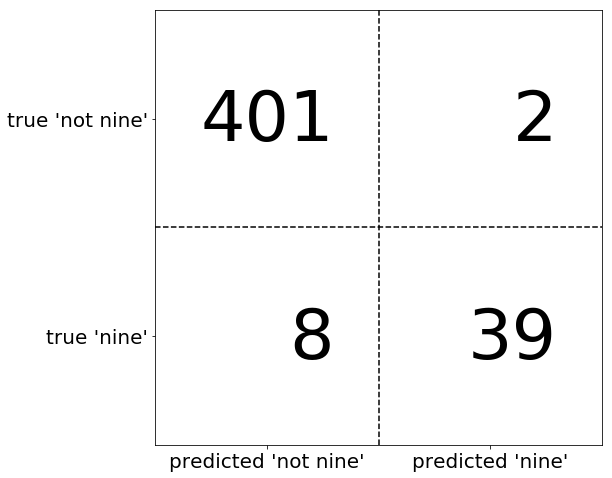

In [7]:
mglearn.plots.plot_confusion_matrix_illustration()

Entries on the main diagonal of the confusion matrix correspond to correct classifications, while other entries tell us how many samples of one class got mistakenly classified as another class.

If we declare “a nine” the positive class, we can relate the entries of the confusion matrix with the terms false positive and false negative that we introduced earlier. To complete the picture, we call correctly classified samples belonging to the positive class true positives and correctly classified samples belonging to the negative class true negatives. These terms are usually abbreviated FP, FN, TP, and TN and lead to the following interpretation for the confusion matrix:

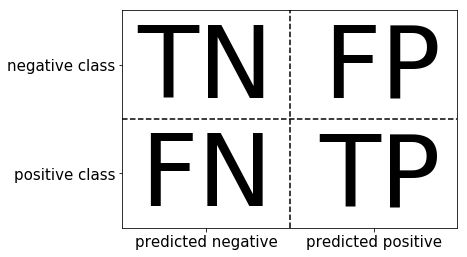

In [8]:
mglearn.plots.plot_binary_confusion_matrix()

Now let’s use the confusion matrix to compare the models we fitted earlier (the two dummy models, the decision tree, and the logistic regression):

In [9]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))

print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))

print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))

print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[367  36]
 [ 45   2]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


Looking at the confusion matrix, it is quite clear that something is wrong with *pred_most_frequent*, because it always predicts the same class. 

*pred_dummy*, on the other hand, has a very small number of true positives, particularly compared to the number of false negatives and false positives—there are many more false positives than true positives! 

The predictions made by the decision tree make much more sense than the dummy predictions, even though the accuracy was nearly the same. 

Finally, we can see that logistic regression does better than pred_tree in all aspects: it has more true positives and true negatives while having fewer false positives and false negatives. 

From this comparison, it is clear that only the decision tree and the logistic regression give reasonable results, and that the logistic regression works better than the tree on all accounts. However, inspecting the full confusion matrix is a bit cumbersome, and while we gained a lot of insight from looking at all aspects of the matrix, the process was very manual and qualitative. There are several ways to summarize the information in the confusion matrix, which we will discuss next.

##### Relation to Accuracy

We already saw one way to summarize the result in the confusion matrix—by computing accuracy, which can be expressed as:

Accuracy =  $\frac{TP + TN}{TP + TN + FP + FN}$

In other words, accuracy is the number of correct predictions (TP and TN) divided by the number of all samples (all entries of the confusion matrix summed up).

##### Precision, Recall, and f-score

There are several other ways to summarize the confusion matrix, with the most common ones being precision and recall. *Precision* measures how many of the samples predicted as positive are actually positive:

Precision = $\frac{TP}{TP + FP}$

Precision is used as a performance metric when the goal is to limit the number of false positives. As an example, imagine a model for predicting whether a new drug will be effective in treating a disease in clinical trials. Clinical trials are notoriously expensive, and a pharmaceutical company will only want to run an experiment if it is very sure that the drug will actually work. Therefore, it is important that the model does not produce many false positives—in other words, that it has a high precision. Precision is also known as *positive predictive value (PPV)*.

*Recall*, on the other hand, measures how many of the positive samples are captured by the positive predictions:

Recall = $\frac{TP}{TP + FN}$

Recall is used as performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives. The cancer diagnosis example from earlier in this chapter is a good example for this: it is important to find all people that are sick, possibly including healthy patients in the prediction. Other names for recall are *sensitivity*, *hit rate*, or *true positive rate (TPR)*.

There is a trade-off between optimizing recall and optimizing precision. You can trivially obtain a perfect recall if you predict all samples to belong to the positive class—there will be no false negatives, and no true negatives either. However, predicting all samples as positive will result in many false positives, and therefore the precision will be very low. On the other hand, if you find a model that predicts only the single data point it is most sure about as positive and the rest as negative, then precision will be perfect (assuming this data point is in fact positive), but recall will be very bad.